# Natural Language Processing with Disaster Tweets
[Kaggle Link](https://www.kaggle.com/competitions/nlp-getting-started/)

## Dataset Description
What files do I need?
You'll need train.csv, test.csv and sample_submission.csv.

## What should I expect the data format to be?
Each sample in the train and test set has the following information:

## The text of a tweet
A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)
What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

## Files
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format

## Columns
id - a unique identifier for each tweet
text - the text of the tweet
location - the location the tweet was sent from (may be blank)
keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
# import libraries
import sys

import keras

from disaster_tweet_detect import data, models
#import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk

#import statsmodels as sm
#import keras as k

# logging
import logging
logging.basicConfig(format='%(message)s', level=logging.INFO, stream=sys.stdout)

nltk.download('stopwords')
nltk.download('punkt')

#spacy

2023-05-03 14:58:32.509156: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mkhung/Documents/Python/UCSD/Capstone/venv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mkhung/nltk_data...
[nltk_data]   Package stopwords is already up

True

## EDA - Data Wrangling and Exploration
1. Look at data
2. Compare distribution of targets
3. Clean duplicates, encoding errors, abbr, etc
4. Tokenize / Word Frequency Map
5. Generate WordCloud
6. Convert tweets to word vectors

In [2]:
# import data
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

### Look at Data
1. Raw data slice
2. Look for duplicated items

We will skip the below items since they are less informative on text

3. <s>Info (count nulls, and look at data types)</s>
4. <s>Describe (shows distribution statistics per column)</s>

#### Summary
'id' will not be useful for classification.
'keyword' only has a few null values.
'location' has several nulls. It may not be a useful feature por predicting disaster tweets as there is no timestamp associated with it.
There are 179 duplicated rows (based on text). Since this is not a lot, we will remove them.

In [3]:
# this slice shows how each column looks
# additionally, it shows some nulls and values in keyword and location columns
data_train[30:35]

,id,keyword,location,text,target
30,44,NaN,NaN,The end!,0
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0


### Compare distributions
While inspecting the distributions between target classes, we can draw the following conclusions
1. Classes are close to balanced
2. Keywords are not missing too many samples and should be dropped
3. Location is missing ~33% - handling unknown (drop column for now)

Portion of Non-Null Data Available
         id   keyword  location  text
target                               
0       1.0  0.995624  0.664210   1.0
1       1.0  0.987160  0.671354   1.0


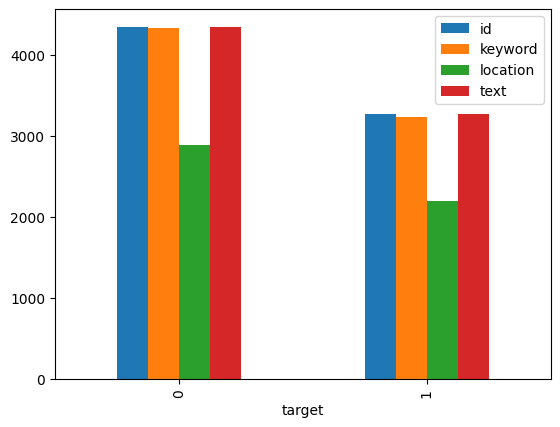

In [4]:
data_train_count = data_train.groupby('target').count()
print('Portion of Non-Null Data Available')
print(data_train_count.div(data_train_count['id'], axis=0))
data_train_count.plot.bar();

## Clean Data
Clean the data for mislabeled and duplicated entries. Since labels are subjectively judged by different people, duplicates may be mislabeled. Keep only the first. Additionally, there are several encoding issues, colloquial terms, abbreviations, concatenations, etc that can be cleaned.

In [5]:
# find duplicates
duplicates = data_train.duplicated(subset=['text'], keep=False)
print(f'There are {sum(duplicates)} duplicated rows')

# remove all but first
duplicates = data_train.duplicated(subset=['text'], keep='first')
data_train_original = data_train
data_train = data_train_original[~duplicates]

print(f'Original length: {len(data_train_original)}\nNew Length: {len(data_train)}')

# clean data
data_train['text_cleaned'] = data_train.text.apply(data.clean)

There are 179 duplicated rows
Original length: 7613
New Length: 7503


/var/folders/jw/5h64zwbd7rg3fd42gmd7ftdw7hp0rl/T/ipykernel_42090/1733787534.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['text_cleaned'] = data_train.text.apply(data.clean)


## Tokenize / Word Frequency Table with NLTK

In [6]:
# build frequency map
df_words = data.count_words_from_series(data_train.text_cleaned)

Unique words: 16876


## Generate WordCloud

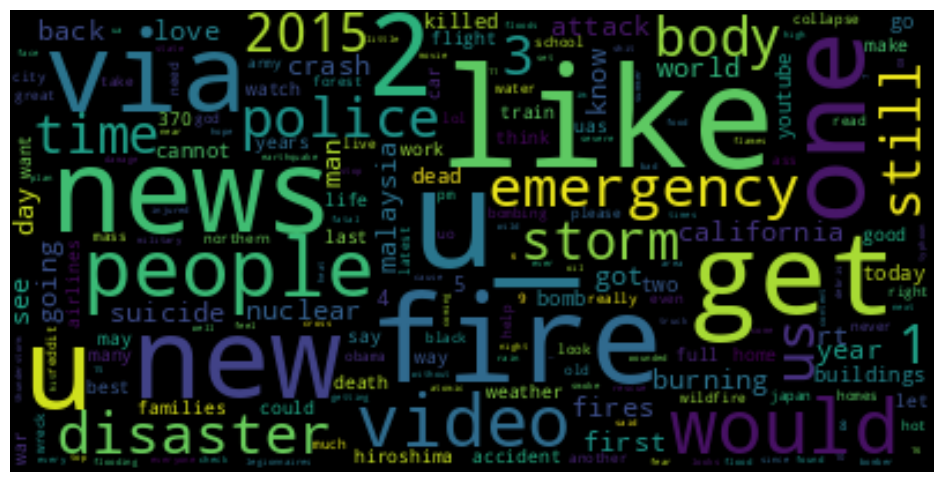

In [7]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=dict(zip(df_words.index, df_words['count'])))
#wordcloud.generate_from_frequencies(frequencies=Counter(words))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Vectorize
TF-IDF is useful for weighing the importance of words. It is computed by multiplying the Term Frequency (TF) vector of each index with a global Inverse Document Frequency (IDF) vector. Unlike the TF vector, the TF-IDF accounts for common words across the document and reduces their weights accordingly.

Vectorize each Tweet. The results are stored in a CSR sparse matrix.

In [8]:
# skip preprocessor as data is already cleaned
vectorizer = TfidfVectorizer(strip_accents='ascii',
                             preprocessor=None,
                             tokenizer=data.tokenizer,
                             stop_words = None)
csr_tfidf = vectorizer.fit_transform(data_train.text_cleaned)

# inspect words with the highest max weight vs lowest
df_tfidf = pd.DataFrame.sparse.from_spmatrix(csr_tfidf.max(axis=0), columns=vectorizer.get_feature_names_out()).transpose().rename(columns={0:'tfidf'})
print(df_tfidf.sort_values(by='tfidf', ascending=False))

# inspect shape
#print(csr_tfidf_train.shape)

/Users/mkhung/Documents/Python/UCSD/Capstone/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


            tfidf
explode  1.000000
wreck    1.000000
crushed  1.000000
fire     1.000000
makes    1.000000
...           ...
tmp      0.199501
oper     0.199501
apch     0.199501
wnd      0.199501
nort     0.182089

[17148 rows x 1 columns]


## ML Models
1. Majority Vote (baseline)
2. Logistic Regression Classifier
3. Ridge Classifier
4. XGBoost Classifier
2. Dense NN - no hidden layers
4. LSTM
7. BERT
3. CNN
5. Random Forest
https://towardsdatascience.com/3-neural-network-architectures-you-need-to-know-for-nlp-5660f11281be

In [9]:
# helper class simplifies summarizing models and metrics
summary = models.Summary()

# split data
X = csr_tfidf.toarray()
y = data_train.target

X_train_tfidf, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

In [10]:
# majority vote classifier
models.evaluate_majority_vote_classifier(X_train_tfidf, X_test, y_train, y_test, summary)

Majority Vote Classifier accuracy: 0.573901
Majority Vote Classifier roc_auc: 0.5


In [11]:
# logistic regression classifier
models.evaluate_logistic_regression_classifier(X_train_tfidf, X_test, y_train, y_test, summary)

Logistic Regression Classifier accuracy: 0.784288
Logistic Regression Classifier roc_auc: 0.761362


In [12]:
# ridge regression classifier
models.evaluate_ridge_classifier('disaster_tweet_detect.ridge.model', X_train_tfidf, X_test, y_train, y_test, summary, retrain=False)

Ridge Classifier accuracy: 0.774967
Ridge Classifier roc_auc: 0.755253


In [13]:
# XGBoost classifier
# xgboost manual: https://xgboost.readthedocs.io/en/stable/parameter.html
# tuning guide: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
models.evaluate_xgboost_classifier('disaster_tweet_detect.xgboost.model', X_train_tfidf, X_test, y_train, y_test, summary, retrain=False)

XGBoost Classifier accuracy: 0.737683
XGBoost Classifier roc_auc: 0.710296


In [14]:
print(summary)

                            model       acc   roc_auc
0        Majority Vote Classifier  0.573901  0.500000
0  Logistic Regression Classifier  0.784288  0.761362
0                Ridge Classifier  0.774967  0.755253
0              XGBoost Classifier  0.737683  0.710296


Working on embedding layer
help from:
https://vgpena.github.io/classifying-tweets-with-keras-and-tensorflow/
https://www.tensorflow.org/tutorials/load_data/text#prepare_the_dataset_for_training

In [15]:
# example to load and use sklearn pipeline
#pipeline = pipelines.load_pipeline('disaster_tweet_detect.xgboost.pipeline')
#pipeline.predict([['Building the perfect tracklist to life leave the streets ablaze']])
#type(pipeline.predict)

### BERT Model

Using A Lite BERT (ALBERT) model as it is faster to train and execute with minimal performance hit.

In [16]:
# split data into train/validation/test
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(data_train.text_cleaned, data_train.target, train_size=0.9, random_state=42)

#models.train_bert_classifier(data_train.text_cleaned, data_train.target)
models.evaluate_bert_classifier("disaster_tweet_detect.albert.keras", X_train_bert, X_test_bert, y_train_bert, y_test_bert, summary, retrain=False)

Using /var/folders/jw/5h64zwbd7rg3fd42gmd7ftdw7hp0rl/T/tfhub_modules to cache modules.


2023-05-03 14:59:36.869426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-03 14:59:36.869784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-03 14:59:36.869906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-03 14:59:36.870229: I tensorflow/core/

24/24 [==============================] - 105s 4s/step
ALBERT Classifier accuracy: 0.814913
ALBERT Classifier roc_auc: 0.804542


In [17]:
print(summary)

                            model       acc   roc_auc
0        Majority Vote Classifier  0.573901  0.500000
0  Logistic Regression Classifier  0.784288  0.761362
0                Ridge Classifier  0.774967  0.755253
0              XGBoost Classifier  0.737683  0.710296
0               ALBERT Classifier  0.814913  0.804542


In [18]:
# # plot training history
# bert_train_acc = history.history['binary_accuracy']
# bert_val_acc = history.history['val_binary_accuracy']
# bert_train_loss = history.history['loss']
# bert_val_loss = history.history['val_loss']
# bert_epochs = range(1, len(bert_train_acc) + 1)
#
# fig,axs = plt.subplots(2, figsize=(10,6))
# axs[0].plot(bert_epochs, bert_train_loss, 'r', label='Training Loss')
# axs[0].plot(bert_epochs, bert_val_loss, 'b', label='Validation Loss')
# axs[0].set_title('Training and Validation Losses')
# axs[0].set_ylabel('Loss')
# axs[0].legend()
#
# axs[1].plot(bert_epochs, bert_train_acc, 'r', label='Training Accuracy')
# axs[1].plot(bert_epochs, bert_val_acc, 'b', label='Validation Accuracy')
# axs[1].set_title('Training and Validation Accuracy')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Accuracy')
# axs[1].legend()